In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random as ra
import math

from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

In [10]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [3]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 128
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #128 - 64
        self.fc2 = nn.Linear(hidden_size1, out_size)       #64 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [6]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [7]:
file_pth = 'binary_ffn_all.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained

<All keys matched successfully>

In [8]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.62 %


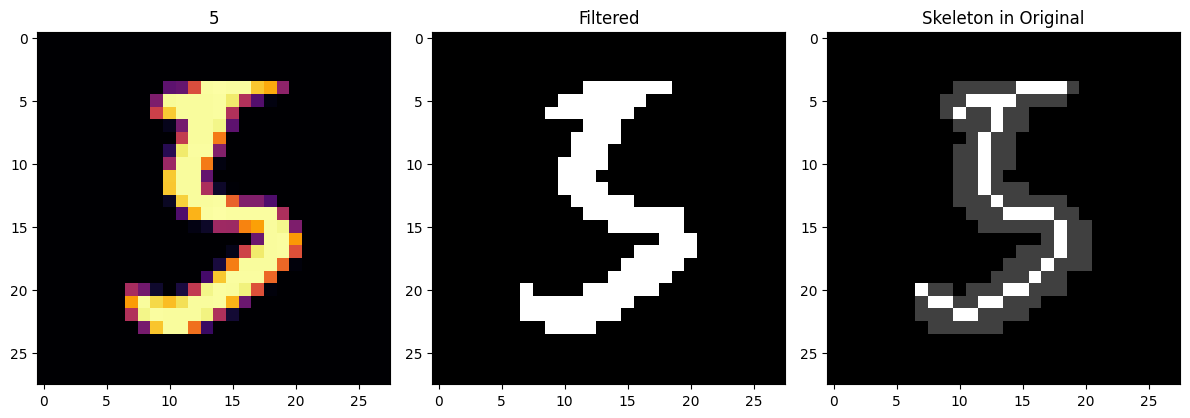

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 5: #ra.randint(0, 9):
        img = inputs[ind].squeeze()
        break

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="inferno")
pred = torch.argmax(net(img.view(-1).cuda())).item()
plt.title(pred)

img_np = img.cpu().numpy()
filtered = img_np > 0.4 #becuase skeleton works on binary 1, 0 data

skeleton = skeletonize(filtered)

plt.subplot(1, 3, 2)
plt.title("Filtered")
plt.imshow(filtered, cmap='gray')

"""plt.subplot(1, 3, 2)
plt.title("Skeletonized")
plt.imshow(skeleton, cmap='gray')"""

actual = torch.where(
    img == 0,
    torch.tensor(0.0, device=img.device),
    0.25
)

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1

plt.subplot(1, 3, 3)
plt.title("Skeleton in Original")
plt.imshow(actual, cmap="gray")

plt.tight_layout()
plt.show()

pseudo code:

define algorithmic direction sequence for R¹ structure with thresholds
try to find all connected skeleton parts that present such a define structure
order these by size (size = max distance of two pixels on the 28x28 map)
store angle, location, all in combination for each input

get original pixels involved in skeleton for each conecpt per input
get full influence of that concept and the implied class(es)
based on implied class(es), gather scores for which class it should be (combination = overlapping to only one class would be optimal outcome)

let FFN learn class based on these compositions
use concept relations in new digits -> one- / few-shot learner?


In [93]:

foreground = np.argwhere(skeleton == 1)
foreground_set = set(map(tuple, foreground))

neighbors8 = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]

def dfs(coord, visited, path): #dfs with backtracking, existing algo
    visited.add(coord)
    path.append(coord)
    max_path = list(path)

    for dx, dy in neighbors8: #all x+dx, y+dy
        next_coord = (coord[0] + dx, coord[1] + dy)
        if next_coord in foreground_set and next_coord not in visited:
            result_path = dfs(next_coord, visited.copy(), path.copy())
            if len(result_path) > len(max_path):
                max_path = result_path

    return max_path

longest_path = []
for coord in foreground:
    path = dfs(tuple(coord), set(), [])
    if len(path) > len(longest_path):
        longest_path = path



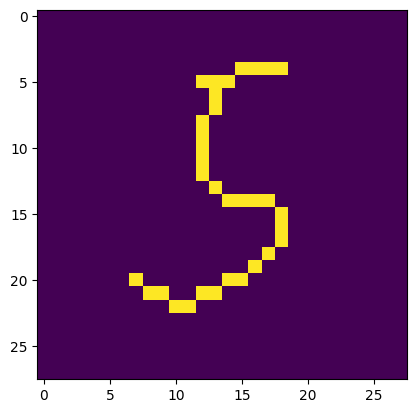

In [94]:
skel = torch.zeros_like(torch.from_numpy(skeleton))
for coo in longest_path:
    x, y = coo
    skel[x, y] = 1

plt.imshow(skel)

#actually needs to try out all pixels for concepts, longest may exclude important combination path

In [75]:
vectors = []
absolute_angles = []

for i, coo in enumerate(longest_path):
    k = 1 if not i == len(longest_path) - 1 else 0
    vec = (longest_path[i+k][1] - coo[1], coo[0] - longest_path[i+k][0])
    vectors.append(vec)
    absolute_angles.append(np.arctan2(vec[1], vec[0]))



In [95]:
foreground_set

{(4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 10),
 (6, 13),
 (7, 13),
 (8, 12),
 (9, 12),
 (10, 12),
 (11, 12),
 (12, 12),
 (13, 13),
 (14, 14),
 (14, 15),
 (14, 16),
 (14, 17),
 (15, 18),
 (16, 18),
 (17, 18),
 (18, 17),
 (19, 16),
 (20, 7),
 (20, 14),
 (20, 15),
 (21, 8),
 (21, 9),
 (21, 12),
 (21, 13),
 (22, 10),
 (22, 11)}

In [76]:
for i, value in enumerate(absolute_angles):
    k = 1 if not i == len(absolute_angles) - 1 else 0
    print(value, " | ", absolute_angles[i+k]-absolute_angles[i])

3.141592653589793  |  0.0
3.141592653589793  |  -5.497787143782138
-2.356194490192345  |  5.497787143782138
3.141592653589793  |  0.0
3.141592653589793  |  0.0
3.141592653589793  |  0.0
3.141592653589793  |  0.0
3.141592653589793  |  0.0
3.141592653589793  |  0.0
3.141592653589793  |  -0.7853981633974483
2.356194490192345  |  -3.9269908169872414
-1.5707963267948966  |  -0.7853981633974483
-2.356194490192345  |  0.7853981633974483
-1.5707963267948966  |  0.0
-1.5707963267948966  |  0.0
-1.5707963267948966  |  -0.7853981633974483
-2.356194490192345  |  2.356194490192345
0.0  |  -0.7853981633974483
-0.7853981633974483  |  0.7853981633974483
0.0  |  -0.7853981633974483
-0.7853981633974483  |  0.7853981633974483
0.0  |  -0.7853981633974483
-0.7853981633974483  |  0.7853981633974483
0.0  |  -0.7853981633974483
-0.7853981633974483  |  -0.7853981633974483
-1.5707963267948966  |  0.7853981633974483
-0.7853981633974483  |  -0.7853981633974483
-1.5707963267948966  |  0.0
-1.5707963267948966  |  -

In [81]:
angles = []

for i, _ in enumerate(vectors):
    k = 1 if not i == len(longest_path) - 1 else 0
    angle = np.arctan2(vectors[i+k][1], vectors[i+k][0]) - np.arctan2(vectors[i][1], vectors[i][0])
    angle = (angle + np.pi) % (2 * np.pi) - np.pi #normalise into [-pi, pi) -> -pi included, pi excluded
    angles.append(angle)
    
    

In [82]:
#angles #index absolute slope from angles in vectors!